# Lliurament 3. Regressió

Aquesta és la tasca del tercer lliurament de Sistemes d'Aprenentatge Automàtic.

Aplicarem a unes mateixes dades tres mètodes de regressió: regressió lineal simple, regressió robusta amb RANSAC i regressió amb arbres.

Té setze apartats preguntes que puntuen tots igual: $0.625$ punts cadascun.

Preneu com a guia el següent **[quadern de regressió](https://colab.research.google.com/drive/1EBCxdZ-VD_xPzKIbuLg1NSZj74hKWXiw?usp=sharing)**.

## 1. Preparació de les dades

a) Carregau el conjunt de dades Boston Housing.

b) Considerau $x$ el nombre de cambres i $y$ el preu de l'habitatge.

c) Representau la gràfica d'$y$ en funció de $x$ sense escalar.

d) Obteniu versions escalades de les variables $x$ i $y$, amb els noms $x\_std$ i $y\_std$.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_url = "http://lib.stat.cmu.edu/datasets/boston"
'''
Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
'''

df = pd.read_csv(data_url, sep="\s+", engine='python', skiprows=22, header=None)
data=np.hstack([df.values[::2,0:11], df.values[1::2,0:3]])
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PRATIO', 'B', 'LSTAT', 'MEDV']
df=pd.DataFrame(data,columns=columns)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


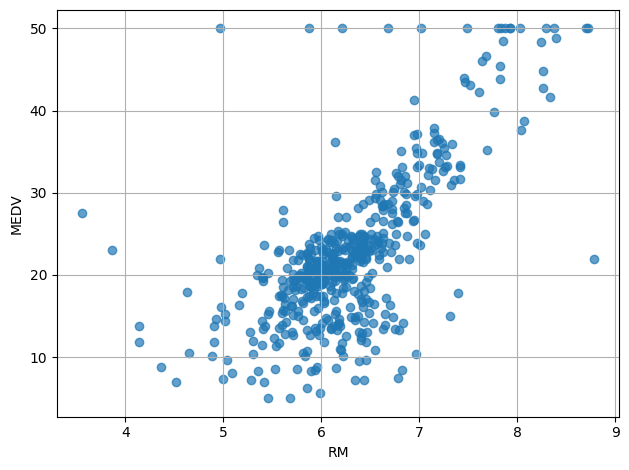

In [44]:
X = df['RM']
y = df['MEDV']

plt.scatter(X, y, alpha=0.7)
plt.xlabel('RM')
plt.ylabel('MEDV')

plt.tight_layout()
plt.grid(True)
plt.show()


sc = StandardScaler()
X_std = sc.fit_transform(X.values.reshape(-1, 1))
y_std = sc.fit_transform(y.values.reshape(-1, 1))

## 2. Regressió lineal

a) Ajustau un predictor lineal a les variables d'entrada i sortida escalades.

b) Obteniu el valor de l'entrada escalada $x\_std$ quan $x=6$ cambres.

c) Amb el model de predicció, obteniu el valor de la sortida escalada $y\_std$.

d) Desescalau la sortida per obtenir el preu. Quin és el preu predit per a un habitatge de $6$ cambres? Contrastau el vostre resultat a la gràfica de l'apartat 1c, per confirmar que té sentit.

In [45]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_std, y_std)

X_six = 6
X_six_std = sc.transform(np.array([[X_six]]))

y_six_std = lr.predict(X_six_std)
y_six = sc.inverse_transform(y_six_std)

print(f'The predicted price for a 6-room apartment is: {y_six[0][0]:.2f}')

The predicted price for a 6-room apartment is: 11.04




In the chart, it can be seen that if you take the horizontal line at `x=6` and the vertical line at `y=~11`, there is a data point that converges at the intersection of these two imaginary lines. However, looking at the accumulation of points when the number of rooms is 6, it tends to be around 20, maybe a little more. As a conclusion, we can infer that the model might not be the most accurate for this case.

## 3. RANSAC

Hi ha una sèrie de dades fora del núvol central. Per això és adequat usar un sistema de regressió robusta. Proposau valors del llindar per aconseguir diferents proporcions de punts com a *inliers*.

a) Obteniu tres llindars (*threshold*) diferents, que ajustin la recta a aproximadament una quarta part dels punts, la meitat dels punts i tres quartes parts dels punts.

b) Representau gràficament les tres situacions de l'apartat anterior.

c) Obteniu les tres prediccions del preu de l'habitatge de quatre cambres segons els tres models.

d) Comentau la diferència entre els tres resultats d'aquesta pregunta i comparau-los també amb el resultat de la pregunta anterior. Se semblen bastant les prediccions? Són molt diferents?

Threshold: 0.13, Inliers: 129, Total points: 506, Proportion: 25 %
Threshold: 0.32, Inliers: 257, Total points: 506, Proportion: 51 %
Threshold: 0.82, Inliers: 414, Total points: 506, Proportion: 82 %


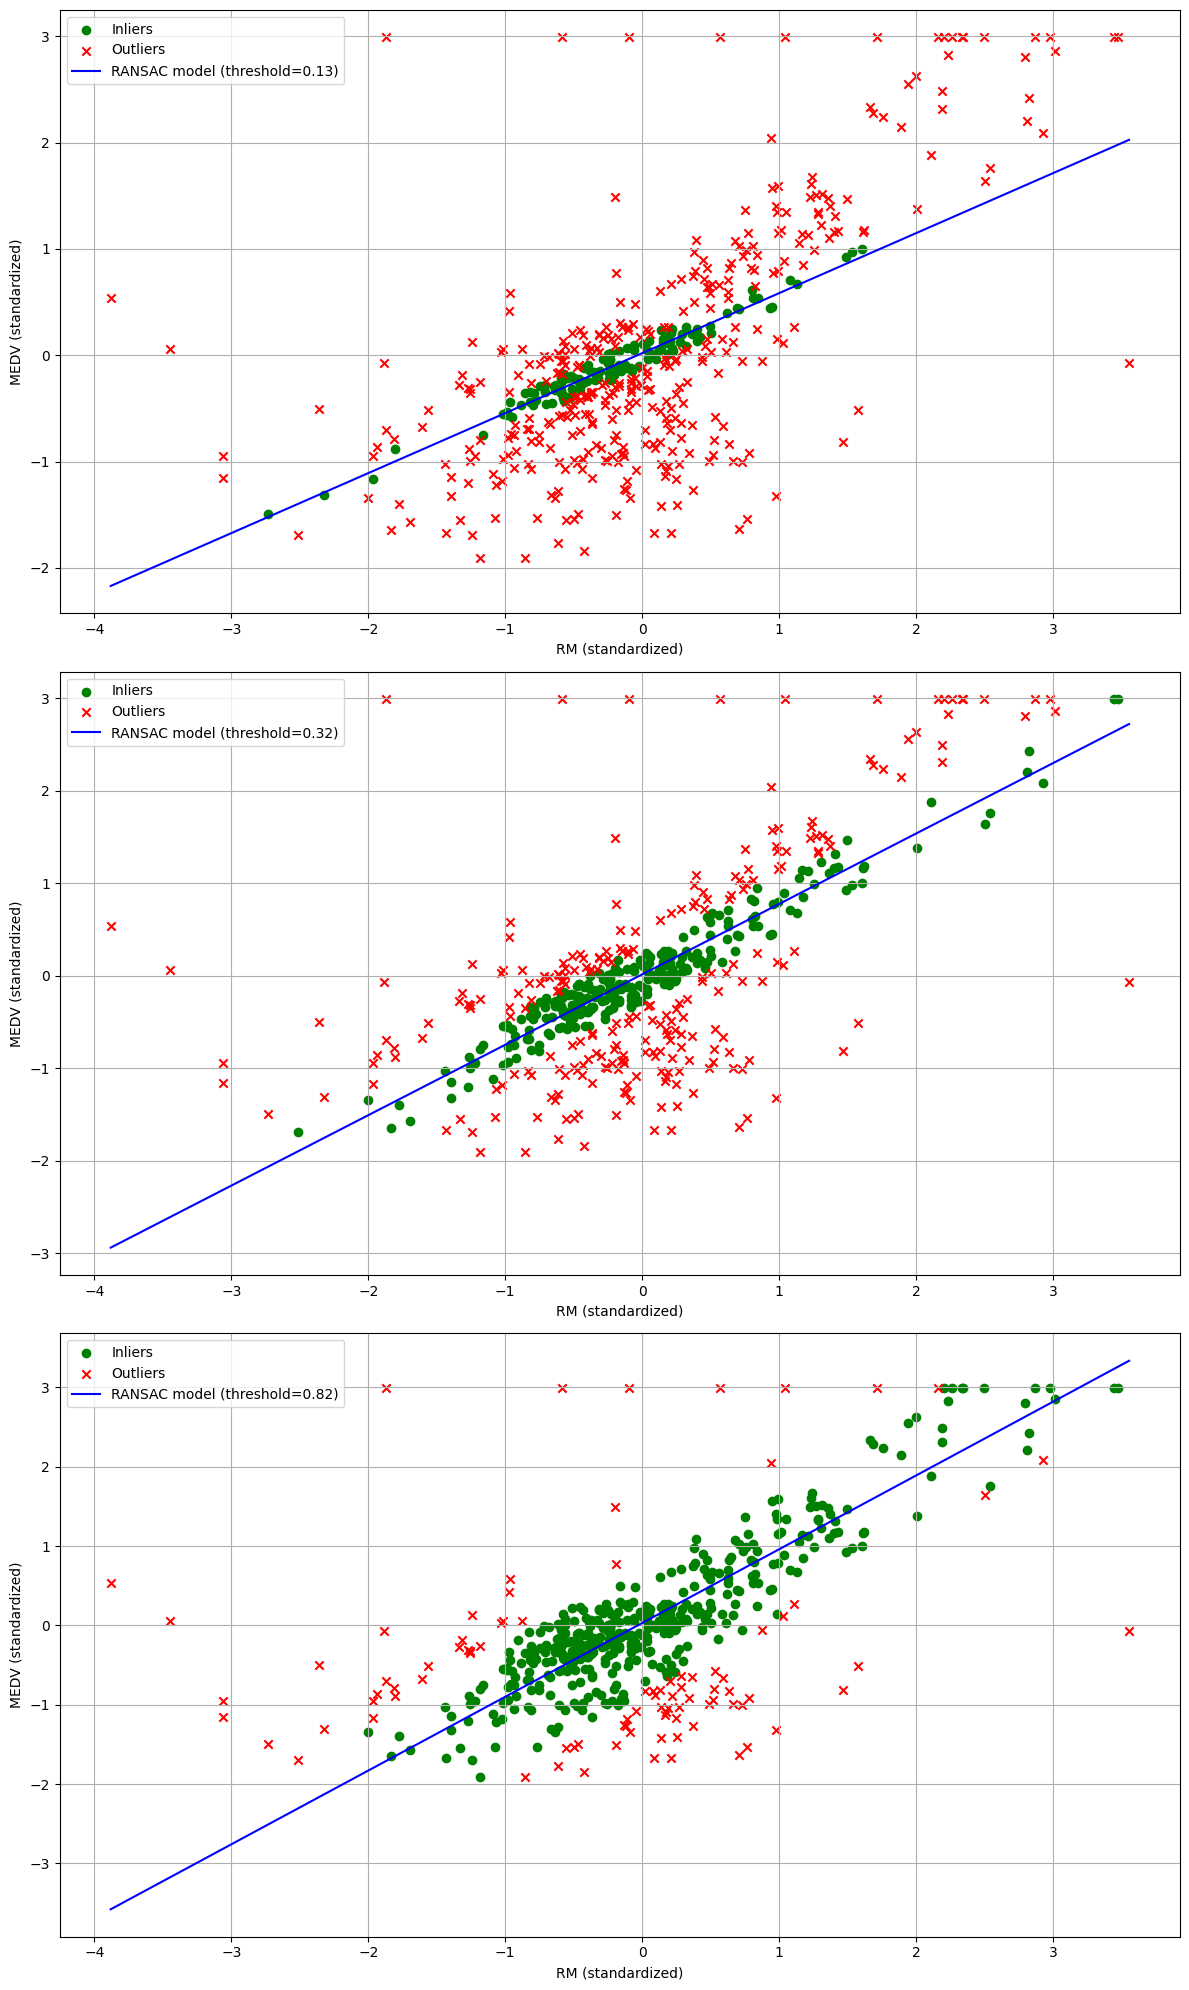

In [46]:
from sklearn.linear_model import RANSACRegressor

thresholds = [0.13, 0.32, 0.82] # Modify the thresholds as pleased
ransac_models = []

for threshold in thresholds:
	ransac = RANSACRegressor(residual_threshold=threshold)
	ransac.fit(X_std, y_std)
	ransac_models.append(ransac)
	
	inliers = sum(ransac.inlier_mask_)
	total_points = len(ransac.inlier_mask_)
	proportion = inliers / total_points
	print(f'Threshold: {threshold}, Inliers: {inliers}, Total points: {total_points}, Proportion: {proportion * 100:.0f} %')

plt.figure(figsize=(12, 20))
for i, ransac in enumerate(ransac_models):
	line_X = np.linspace(X_std.min(), X_std.max(), 1000).reshape(-1, 1)
	line_y = ransac.predict(line_X)
	inlier_mask = ransac.inlier_mask_
	outlier_mask = np.logical_not(inlier_mask)
	
	plt.subplot(len(thresholds), 1, i + 1)
	plt.scatter(X_std[inlier_mask], y_std[inlier_mask], color='green', marker='o', label='Inliers')
	plt.scatter(X_std[outlier_mask], y_std[outlier_mask], color='red', marker='x', label='Outliers')
	plt.plot(line_X, line_y, color='blue', label=f'RANSAC model (threshold={thresholds[i]})')
	plt.xlabel('RM (standardized)')
	plt.ylabel('MEDV (standardized)')
	plt.legend()
	plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
predictions = []
for ransac in ransac_models:
	y_six_std = ransac.predict(X_six_std)
	y_six = sc.inverse_transform(y_six_std)
	predictions.append(y_six[0][0])

# Imprimir las predicciones
for i, prediction in enumerate(predictions):
	print(f'The predicted price for a 6-room apartment with threshold {thresholds[i]} is: {prediction}')

The predicted price for a 6-room apartment with threshold 0.13 is: 13.386079371821646
The predicted price for a 6-room apartment with threshold 0.32 is: 10.063866401156556
The predicted price for a 6-room apartment with threshold 0.82 is: 7.43164634866875


Comparing LinearRegression results and RANSAC results we can see that they might vary depending on the threshold used. The lower the threshold is, the prediction is closer to a real values (we said that it was around 20).

## 4. Regressió amb arbres de decisió

a) Ajustau tres arbre de regressió a les mateixes dades que les preguntes anteriors, de forma que obtengueu infraajust, sobreajust i un bon ajust.

b) Representau les tres gràfiques dels models superposades al núvol de punts.

c) Quin és el preu predit per a un habitatge de 6 cambres amb el model de més bon ajust?

d) Comparau aquest resultat amb els dels models lineal simple i RANSAC.

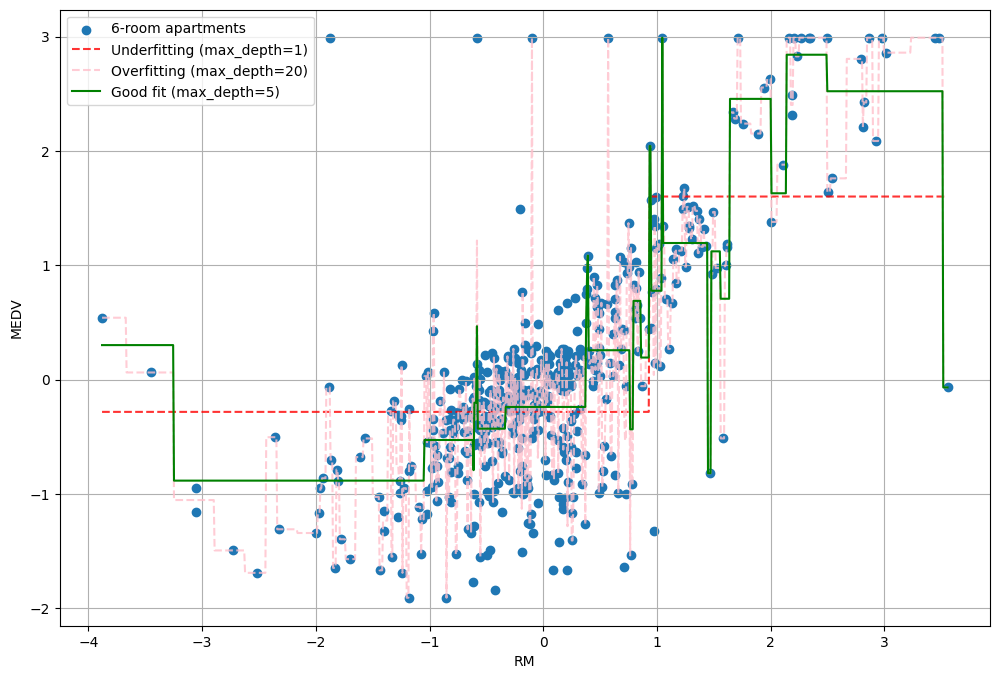

The predicted price for a 6-room apartment using the good fit model is: 14.41


In [48]:
from sklearn.tree import DecisionTreeRegressor

dt_underfit = DecisionTreeRegressor(max_depth=1)
dt_overfit = DecisionTreeRegressor(max_depth=20)
dt_goodfit = DecisionTreeRegressor(max_depth=5)
dt_underfit.fit(X_std, y_std)
dt_overfit.fit(X_std, y_std)
dt_goodfit.fit(X_std, y_std)

plt.figure(figsize=(12, 8))
plt.scatter(X_std, y_std, label='6-room apartments')

line_y_underfit = dt_underfit.predict(line_X)
plt.plot(line_X, line_y_underfit, color='red', linestyle='--', label='Underfitting (max_depth=1)', alpha=0.8)

line_y_overfit = dt_overfit.predict(line_X)
plt.plot(line_X, line_y_overfit, color='pink', linestyle='--', label='Overfitting (max_depth=20)', alpha=0.8)

line_y_goodfit = dt_goodfit.predict(line_X)
plt.plot(line_X, line_y_goodfit, color='green', label='Good fit (max_depth=5)')

plt.xlabel('RM')
plt.ylabel('MEDV')
plt.legend()
plt.grid(True)
plt.show()

y_six_dt_std = dt_goodfit.predict(X_six_std)
y_six_dt = sc.inverse_transform(y_six_dt_std.reshape(-1, 1))

print(f'The predicted price for a 6-room apartment using the good fit model is: {y_six_dt[0][0]:.2f}')

## Conclusion

### Linear Regression
- **Predicted price for a 6-room apartment:** 11.04

It was possible if the first chart is checked but not close to the 'real' value that was around 20.

### RANSAC Regression
- **Predicted prices for a 6-room apartment:**
	- **Threshold 0.13:** 13.39
	- **Threshold 0.32:** 10.06
	- **Threshold 0.82:** 7.43

The less threshold, closer the predcition will be to the 'real' value.

### Decision Tree Regression
- **Predicted price for a 6-room apartment (best fit model):** 14.41

Closer this time but still not quite the final solution in my opinion.

### Final Thoughts
The **Decision Tree Regression** model with the best fit predicts the highest price for a 6-room apartment even though is still not quite close to the data concentration in the chart.

Overall, the choice of regression method can significantly impact the predicted prices, and each method has its strengths and weaknesses depending on the data and the specific requirements of the analysis.